#### [第一个测试](https://syyrjx.xyz/blog?id=86)

包导入

In [17]:
import pytesseract
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import numpy as np

###### 图像预处理（比例放缩）

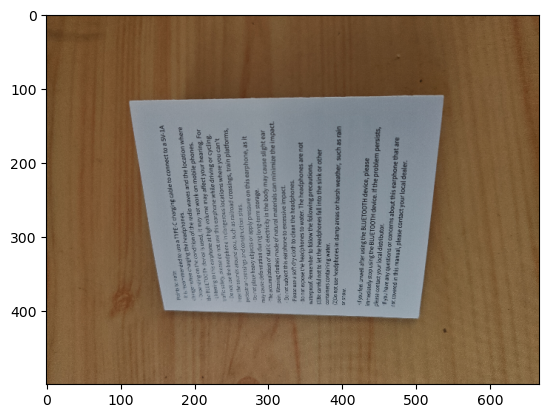

In [8]:
# page = cv2.imread('./images/1.jpg')
page = cv2.imread('./images/page.jpg')
ratio  = 500.0 / page.shape[0]
# 放缩比例
page_original = page.copy()
page_resize = cv2.resize(page_original,(int(page.shape[1] * ratio),500))

plt.imshow(cv2.cvtColor(page_resize, cv2.COLOR_BGR2RGB))
plt.show()

##### 图像转为二值图像

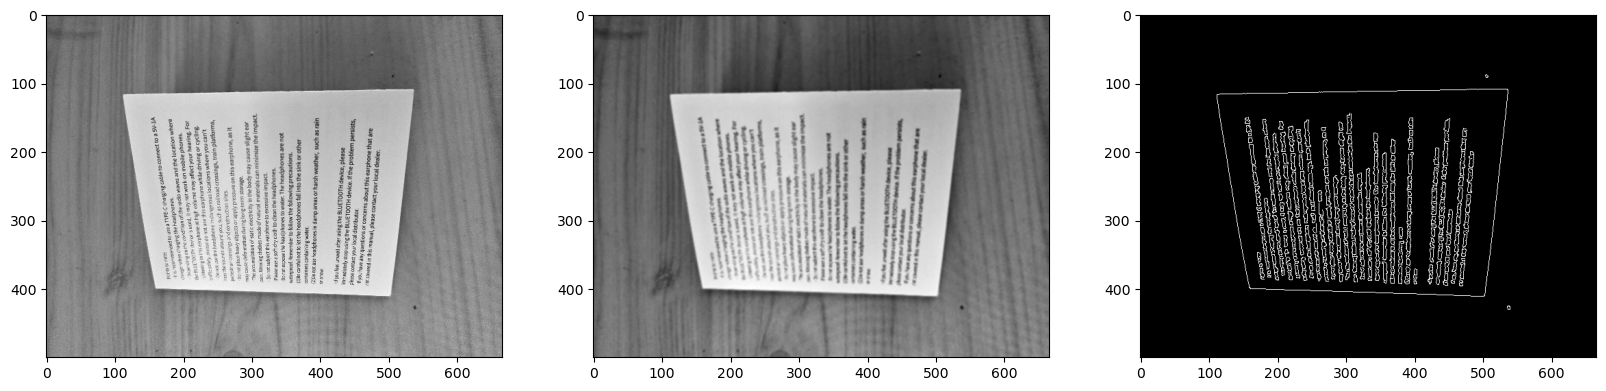

In [9]:
# 转灰度图
page_gray = cv2.cvtColor(page_resize, cv2.COLOR_BGR2GRAY)
# 将图像从 BGR 转换为 RGB
page_rgb = cv2.cvtColor(page_resize, cv2.COLOR_BGR2RGB)
# 高斯滤波，去除噪点
page_guassion = cv2.GaussianBlur(page_gray,(5,5),0)
# canny边缘检测
page_canny = cv2.Canny(page_guassion, 30, 100)

plt.figure(figsize=(20,25))
plt.subplot(131)
plt.imshow(page_gray, 'gray')

plt.subplot(132)
plt.imshow(page_guassion, 'gray')

plt.subplot(133)
plt.imshow(page_canny, 'gray')

plt.show()

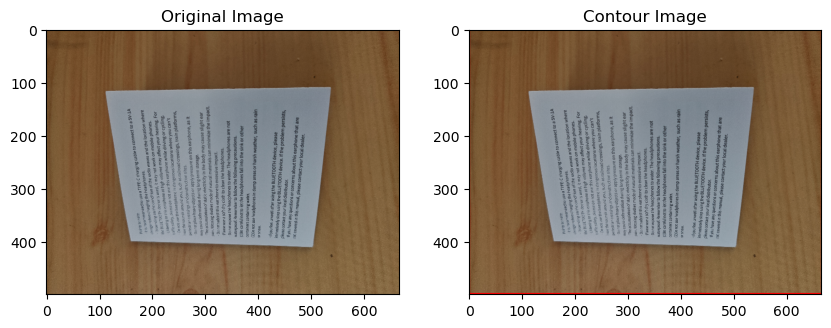

In [10]:
# 二值化图像
_, binary_image = cv2.threshold(page_gray, 128, 255, cv2.THRESH_BINARY_INV)

# 查找轮廓
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 绘制轮廓
contour_image = page_rgb.copy()
cv2.drawContours(contour_image, contours, -1, (255, 0, 0), 2)  # 用蓝色绘制轮廓

# 显示原始图像和轮廓图像
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(page_rgb)
plt.title('Original Image')
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(contour_image)
plt.title('Contour Image')
# plt.axis('off')

plt.show()

###### 获得目标图像外轮廓
轮廓检测会得到很多的轮廓，这里通过周长比较，拿到周长最长的（在实验图像中，显然周长最长的轮廓是外轮廓）

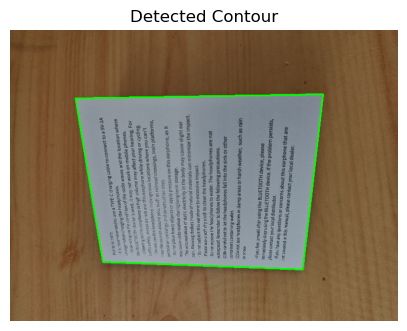

In [11]:
# 确保 page_canny 已经定义
# 确保 page_resize 已经定义

# 轮廓检测
contours, hierarchy = cv2.findContours(page_canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

page_cnt = None
page_cnt_arc = 0

# 最大周长的轮廓
for contour in contours:
    # 计算近似轮廓
    arc_length = cv2.arcLength(contour, True)
    approx_curve = cv2.approxPolyDP(contour, 0.05 * arc_length, True)

    # 取最大周长的轮廓
    approx_length = cv2.arcLength(approx_curve, True)
    if approx_length > page_cnt_arc:
        page_cnt = approx_curve
        page_cnt_arc = approx_length

# 确保找到轮廓后再绘制
if page_cnt is not None:
    page_temp = page_resize.copy()
    cv2.drawContours(page_temp, [page_cnt], -1, (0, 255, 0), 2)

    plt.figure(figsize=(5, 10))
    plt.imshow(cv2.cvtColor(page_temp, cv2.COLOR_BGR2RGB))
    plt.title('Detected Contour')
    plt.axis('off')
    plt.show()
else:
    print("No contour found.")

###### 构建透视变换的原矩阵和目标矩阵

原始 [[[537 110]]

 [[112 117]]

 [[159 398]]

 [[502 411]]]
处理 [[3286.44     673.19995]
 [ 685.44     716.04   ]
 [ 973.07996 2435.76   ]
 [3072.24    2515.3198 ]]
顶点 [3286.44     673.19995] [685.44 716.04] [ 973.07996 2435.76   ] [3072.24   2515.3198]
[[[3286  673]]

 [[ 685  716]]

 [[ 973 2435]]

 [[3072 2515]]]


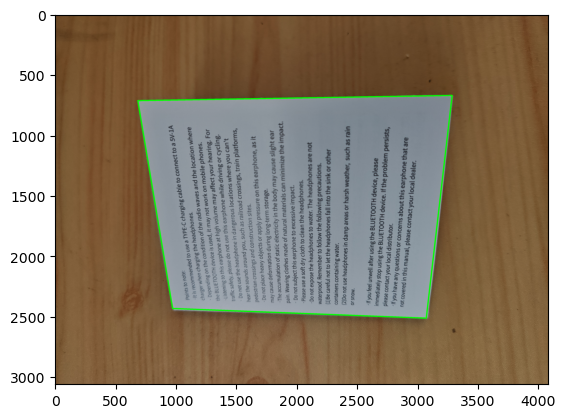

目标 [[   0. 2601.]
 [2989. 2601.]
 [2989.    0.]
 [   0.    0.]]
[[[   0 2601]]

 [[2989 2601]]

 [[2989    0]]

 [[   0    0]]]


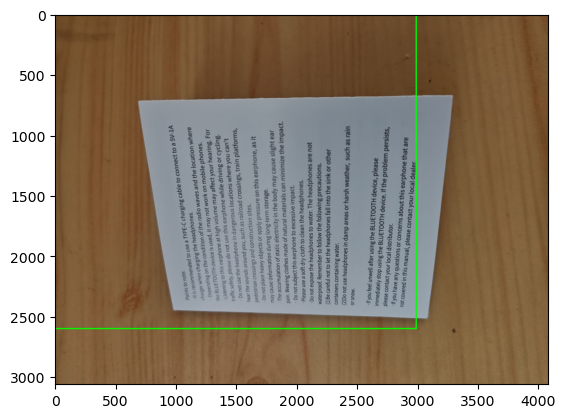

In [12]:
print('原始',page_cnt)
page_cnt_deal = np.float32(page_cnt[:,0,:]) / ratio
print('处理',page_cnt_deal)
A,B,C,D = page_cnt_deal 
print('顶点',A,B,C,D)

# 在原始图像上画轮廓
page_temp = page.copy()
page_cnt_deal_temp = np.array([[np.int32(A)],[np.int32(B)],[np.int32(C)],[np.int32(D)]])
print(page_cnt_deal_temp)
cv2.drawContours(page_temp, [page_cnt_deal_temp], -1, (0,255,0),10)
plt.imshow(cv2.cvtColor(page_temp, cv2.COLOR_BGR2RGB))
plt.show()

W1 = np.sqrt((A[0] - B[0]) ** 2 + (A[1] -B[1]) ** 2)
W2 = np.sqrt((C[0] -D[0]) ** 2 + (C[1] -D[1]) ** 2)
W = max(int(W1), int(W2))

H1 = np.sqrt((A[0] - C[0]) ** 2 + (A[1] -C[1]) ** 2)
H2 = np.sqrt((B[0] -D[0]) ** 2 + (B[1] -D[1]) ** 2)
H = max(int(H1), int(H2))

# 目标坐标
dest = np.array([
    [0,W],
    [H,W],
    [H,0],
    [0,0]
], dtype=np.float32)

print('目标',dest)

# 在原始图像上画轮廓
page_temp = page.copy()
page_cnt_deal_temp = np.array([[np.int32(dest[0])],[np.int32(dest[1])],[np.int32(dest[2])],[np.int32(dest[3])]])
print(page_cnt_deal_temp)
cv2.drawContours(page_temp, [page_cnt_deal_temp], -1, (0,255,0),10)
plt.imshow(cv2.cvtColor(page_temp, cv2.COLOR_BGR2RGB))
plt.show()

###### 透视变换
这里创建出的矩阵M就是原坐标矩阵pagecntdeal到目标坐标矩阵dest的变换矩阵。

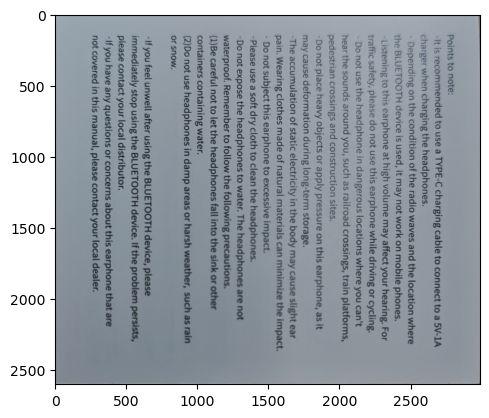

In [13]:
# 透视变换
M = cv2.getPerspectiveTransform(page_cnt_deal, dest)
page_warped = cv2.warpPerspective(page, M, (int(H),int(W)))

plt.imshow(cv2.cvtColor(page_warped, cv2.COLOR_BGR2RGB))
plt.show()

###### 二值化处理
这里二值化处理是为了ocr识别更清晰

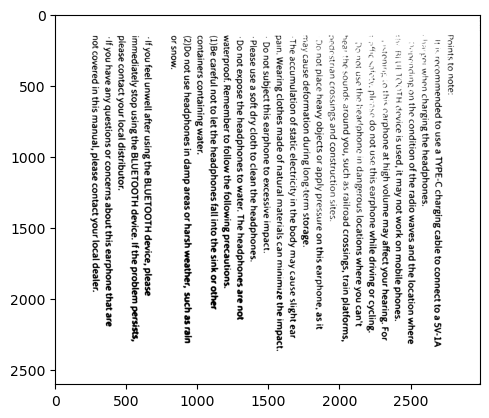

In [23]:
# 二值化
page_warped_gray = cv2.cvtColor(page_warped, cv2.COLOR_BGR2GRAY)
res,page_warped_bin = cv2.threshold(page_warped_gray, 100,255, cv2.THRESH_BINARY)

plt.imshow(page_warped_bin,'gray')
plt.show()

#### 二、tesseract-orc识别

###### 使用tesseract识别刚刚透视转换的结果

In [21]:
# import pytesseract

# 如果在 Windows 上，需要明确设置 tesseract_cmd 路径
# pytesseract.pytesseract.tesseract_cmd = r'D:\Program Files\Tesseract-OCR\tesseract.exe'

# 如果在其他系统上，确保 tesseract 已正确安装并在系统路径中  /usr/bin/tesseract
pytesseract.pytesseract.tesseract_cmd = r'/bin/tesseract'


In [22]:
text = pytesseract.image_to_string(page_warped_bin, lang='chi_sim')
print(text)

TesseractError: (1, 'Error opening data file /usr/share/tesseract-ocr/4.00/tessdata/chi_sim.traineddata Please make sure the TESSDATA_PREFIX environment variable is set to your "tessdata" directory. Failed loading language \'chi_sim\' Tesseract couldn\'t load any languages! Could not initialize tesseract.')

In [25]:
print(pytesseract.get_tesseract_version())
print(pytesseract.get_languages())

4.1.1
['eng', 'osd']
